---
**License**

 cmp_cluster_ccl_numcosmo_bias

 Wen Aug 07 15:11:00 2024\
 Copyright  2024\
 Henrique Cardoso Naves Lettieri  <henrique.cnl23@uel.br>
 Mariana Penna-Lima     <pennalima@gmail.com> \
 Sandro Dias Pinto Vitenti <vitenti@uel.br>

---
---

 cmp_cluster_ccl_numcosmo_bias\
 Copyright (C) 2021 Henrique Cardoso Naves Lettieri  <henrique.cnl23@uel.br>, Mariana Penna-Lima <pennalima@gmail.com>, Sandro Dias Pinto Vitenti <vitenti@uel.br>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

<a class="anchor" id="contents"></a>
# Contents

### 1. [Packages](#libraries)
### 2. [Cosmological models](#constants)
### 3. [Halo mass function and Halo Bias](#mass)
### 4. [Unbinned approach](#unbinned)
####     4.1 [Mock catalog](#mock)
####     4.2 [NumCosmo predictions](#numcosmo_ubinned)
####     4.3 [CCL preditictios](#ccl_unbinned)
####     4.4 [Relative error plots](#plots_unbinned)
### 5. [Binned approach](#binned)
####     5.1 [Bins](#bins)
####     5.2 [NumCosmo predictions](#numcosmo_binned)
####     5.3 [CCL preditictios](#ccl_binned)
####     5.4 [Relative error plots](#plots_binned)

<a class="anchor" id="libraries"></a>
## 1.  [Packages](#libraries)
***

In the cell below, we import the libraries `CCL` and `NumCosmo` for comparison between their cluster counts predictions in an unbinned and binned with a richness-proxy.

To import `NumCosmo`, we should import `GObject`. This is important because `GObject` help us to maps the C language in other languages, like python.

The package `sys` is related to the manipulation and obtaining information from the python environment imports the auxiliary library `CLCosmo_Sim` to run the binned counts version of `CCL`. The package `numpy` help us with the calculations, gives us access to mathematical functions, while astropy is used too handle the fits files for the cluster mock catalog.


In [1]:
#!/usr/bin/env python
from numcosmo_py import Ncm, Nc
from numcosmo_py.external.pyssc import pyssc as PySSC
from numcosmo_py.ccl import nc_ccl

Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())
import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy.table import Table




import pyccl as ccl
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')

import sys
sys.path.insert(0,'../../../CLCosmo_Sim/modeling/')
sys.path.insert(0,'../../../CLCosmo_Sim/modeling/old_files/')
import CL_COUNT_modeling_halo_mass_function as hmf
import CL_COUNT_cluster_abundance as cl_count
import old_CL_COUNT_class_cluster_abundance as old_cl_count
import CL_COUNT_modeling_richness_mass_relation as rm_relation

import time

<a class="anchor" id="constants"></a>
## 2. [Cosmological models](#constants)
***
In this cell below we fix the cosmological constants to avoid conflits in the calculations and comparisons between the libraries.


$\Omega_{C}$ = 0.265 The density fraction at z=0 of CDM.<br>
$\Omega_{b}$ = 0.0448 The density fraction at z=0 of baryons.<br>
$\Omega_{k}$ = 0.0 The curvature density fraction at z=0.<br>
$H_{0 }$ = 71.00   The Hubble constant.<br>
$Tcmb_{0}$  = 2.7255 The temperature at z=0 of CMB.<br>
$\sigma_{8}$ = 0.80 The normalization of the power spectrum today. <br>
$n_{s}$ = 0.96 Scalar spectral index.<br>
$N_{eff}$ = 0.0 3.046 effective number of massless+massive neutrinos present at recombination.<br>
$\omega_{0}$ = -1.0 First order term of the dark energy equation of state.<br>
$\omega_{a}$ = 0.0 Second order term of the dark energy equation of state.<br>

In [2]:
# CCL cosmology default paramters
cosmo_ccl_default = ccl.Cosmology(Omega_c=0.265, Omega_b=0.0448, h=0.71, sigma8=0.8, n_s=0.96, Omega_k=0, transfer_function="eisenstein_hu",)


# CCL cosmology high precision paramters
ccl_params = nc_ccl.CCLParams()
ccl_params.set_high_prec_params()

cosmo_ccl_high = ccl.Cosmology(Omega_c=0.265, Omega_b=0.0448, h=0.71, sigma8=0.8, n_s=0.96, Omega_k=0, transfer_function="eisenstein_hu",)

#NumCosmo Cosmology
cosmo_numcosmo, dist, ps_lin, ps_nln, psf = nc_ccl.create_nc_obj(cosmo_ccl_default)

<a class="anchor" id="mass"></a>
## 3.  [Halo Mass Function and Halo Bias](#mass)
***
In the cell above we initialize the halo mass and bias functions objects in both `NumCosmo` and `CCL`

In [3]:
# Numcosmo Halo mass function

# First we define the mass proxy in the first analysis is used the true mass and redshift of the clusters
cluster_m = Nc.ClusterMassNodist(lnM_min=np.log(10) * 14.0, lnM_max=np.log(10) * 16.0)
cluster_z = Nc.ClusterRedshiftNodist(z_min=0.0, z_max=2.0)

sky_area = 5264.05 * (np.pi / 180) ** 2


mulf = Nc.MultiplicityFuncTinker.new()
mulf.set_linear_interp(True)
mulf.set_mdef(Nc.MultiplicityFuncMassDef.CRITICAL)
mulf.set_Delta(200)

hmf_numcosmo = Nc.HaloMassFunction.new(dist, psf, mulf)
hmf_numcosmo.set_area(sky_area)
hbf_numcosmo = Nc.HaloBiasTinker.new(hmf_numcosmo)

ca = Nc.ClusterAbundance.new(hmf_numcosmo, hbf_numcosmo)

mset = Ncm.MSet.new_array([cosmo_numcosmo, cluster_m, cluster_z])
mset.pretty_log()
print("sigma8 = " + str(cosmo_numcosmo.sigma8(psf)))


# CCL halo mass funtion
massdef = ccl.halos.massdef.MassDef(200, "critical")
hmf_ccl = ccl.halos.hmfunc.MassFuncTinker08(mass_def=massdef)
hbf_ccl = ccl.halos.hbias.HaloBiasTinker10(mass_def=massdef)

#----------------------------------------------------------------------------------
# Model[03000]:
#   - NcHICosmo : Chevalier-Polarski-Linder parametrization
#----------------------------------------------------------------------------------
# Model parameters
#   -         H0[00]:  71                  [FIXED]
#   -     Omegac[01]:  0.265               [FIXED]
#   -     Omegak[02]:  0                   [FIXED]
#   -    Tgamma0[03]:  2.7255              [FIXED]
#   -         Yp[04]:  0.24                [FIXED]
#   -       ENnu[05]:  3.044               [FIXED]
#   -     Omegab[06]:  0.0448              [FIXED]
#   -         w0[07]: -1                   [FIXED]
#   -         w1[08]:  0                   [FIXED]
#----------------------------------------------------------------------------------
# Model[05000]:
#   - NcHIPrim : Power Law model for primordial spectra
#----------------------------------------------------------------------------------
# Model parameters
#   - ln10e10ASA[00

<a class="anchor" id="unbinned"></a>
## 4.  [Unbinned approach](#unbinned)
***
In the cells above we compute

$$
b_i = \frac{\Omega_s}{x_i}\frac{d^2V(z_i)}{dz d\Omega}\frac{dn(M_i,z_i)}{d\log_{10}M_i} b(M_i,z_i)
$$

for each masses and redshifts in a dark matter halo catalog

<a class="anchor" id="mock"></a>
### 4.1 [Mock catalog](#mock)

In the cell below we created a the mock catalog to compare the predictions in the unbinned case

In [4]:
# Generates cluster count catalog data
ncdata = Nc.DataClusterNCount.new(ca, "NcClusterRedshiftNodist", "NcClusterMassNodist")
rng = Ncm.RNG.pool_get("example_ca_sampling")
ncdata.init_from_sampling(mset, sky_area, rng)
ncdata.catalog_save("ca_nodist_unbinned_numcosmo.fits", True)

ncdata_fits = fits.open("ca_nodist_unbinned_numcosmo.fits")
# ncdata_fits.info()

ncdata_data = ncdata_fits[1].data

ncdata_Table = Table(ncdata_data)
ncdata_Table.columns
ncdata_Table.sort("Z_TRUE")

display(ncdata_Table)

Z_OBS,LNM_OBS,Z_TRUE,LNM_TRUE
float64,float64,float64,float64
0.007890346272649527,32.36635159604371,0.007890346272649527,32.36635159604371
0.015591514811751285,34.041551801269236,0.015591514811751285,34.041551801269236
0.01717599338712358,32.537203615525954,0.01717599338712358,32.537203615525954
0.01848213196385736,32.3227060349525,0.01848213196385736,32.3227060349525
0.019600144223626857,32.34347663841976,0.019600144223626857,32.34347663841976
0.021016823514802278,32.74269087465621,0.021016823514802278,32.74269087465621
0.021118683603193376,33.32206233673521,0.021118683603193376,33.32206233673521
0.022892522364355766,32.61285219375032,0.022892522364355766,32.61285219375032
0.023343422757394684,34.36947444341765,0.023343422757394684,34.36947444341765


<a class="anchor" id="numcosmo_ubinned"></a>
### 4.2 [NumCosmo predictions](#numcosmo_ubinned)

In [5]:
# Using Numcosmo
t0 = time.time()
d2n_bias_numcosmo = []

for i in ncdata_Table:
    d2n_bias_numcosmo.append(ca.intp_d2n_bias(cosmo_numcosmo, cluster_z, cluster_m, [i[1]], None, [i[0]], None )/ca.d2n(cosmo_numcosmo, cluster_z, cluster_m, i[1], i[0]))
d2n_bias_numcosmo = np.array(d2n_bias_numcosmo)

t1 = time.time()
print("time (seconds) = " + str(t1 - t0))

time (seconds) = 0.9875125885009766


<a class="anchor" id="ccl_ubinned"></a>
### 4.3 [CCL predictions](#ccl_ubinned)

In [7]:
#CCL bias

t0 = time.time()
d2n_bias_ccl_default = []
for i in ncdata_Table:
    d2n_bias_ccl_default.append(hbf_ccl.__call__(cosmo_ccl_default,10**(i[1]/np.log(10)),1/(1+i[0])))

t1 = time.time()
print("time (seconds) = " + str(t1 - t0))

t0 = time.time()
d2n_bias_ccl_high = []
for i in ncdata_Table:
    d2n_bias_ccl_high.append(hbf_ccl.__call__(cosmo_ccl_high,10**(i[1]/np.log(10)),1/(1+i[0])))

t1 = time.time()
print("time (seconds) = " + str(t1 - t0))

time (seconds) = 3.8088037967681885
time (seconds) = 36.59869861602783


<a class="anchor" id="plots_unbinned"></a>
### 4.4 [Relative error plots](#plots_unbinned)

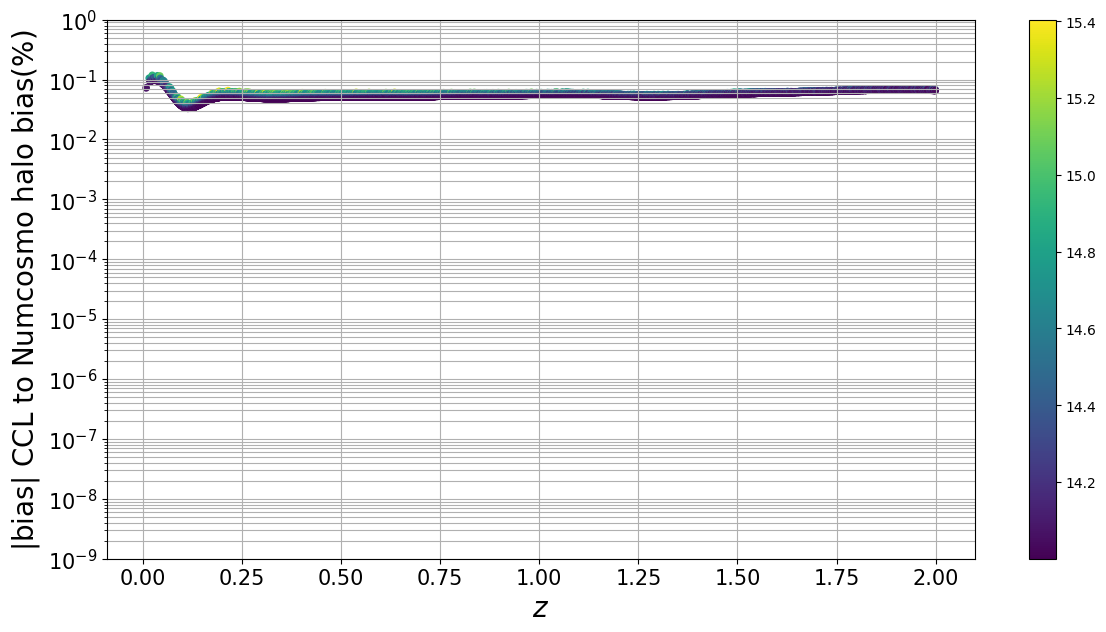

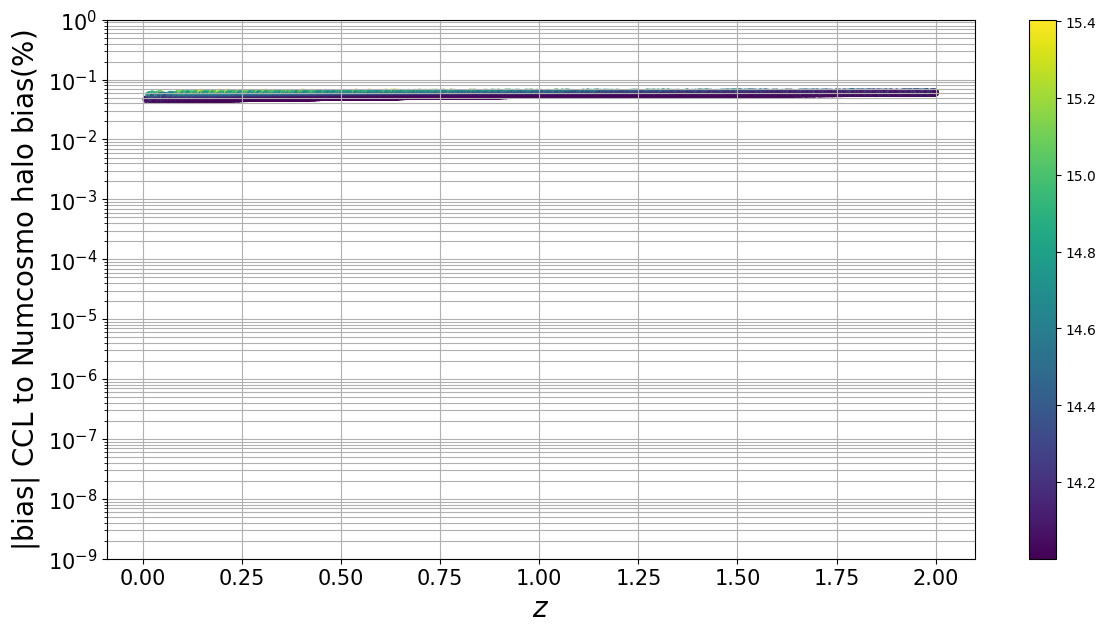

In [8]:
z = []
log10M = []
#default parameters
for i in ncdata_Table:
    z.append(i[0])
    log10M.append(i[1]/np.log(10))

diff = abs(100 * (d2n_bias_ccl_default - d2n_bias_numcosmo) / d2n_bias_numcosmo)

plt.figure(figsize=(14, 7))
plt.yscale("log")

plt.tick_params(axis="both", which="major", labelsize=15)

plt.scatter(z, diff, s=20, c=log10M)
plt.colorbar()
plt.grid(True, which="both")
plt.xlabel(r"$z$", fontsize=20)
plt.ylabel(r"|bias| CCL to Numcosmo halo bias$(\%)$", fontsize=20)
plt.ylim(10e-10, 1)
plt.show()

#high precision parameters
diff = abs(100 * (d2n_bias_ccl_high - d2n_bias_numcosmo) / d2n_bias_numcosmo)

plt.figure(figsize=(14, 7))
plt.yscale("log")
plt.tick_params(axis="both", which="major", labelsize=15)

plt.scatter(z, diff, s=20, c=log10M)
plt.colorbar()
plt.grid(True, which="both")
plt.xlabel(r"$z$", fontsize=20)
plt.ylabel(r"|bias| CCL to Numcosmo halo bias$(\%)$", fontsize=20)
plt.ylim(10e-10, 1)
plt.show()

<a class="anchor" id="binned"></a>
## 5.  [Binned approach](#binned)
***
In the cells above we compute the 2D integral

$$
 b_{\alpha\beta}^{\rm predicted} = \frac{\Omega_s}{N^{predicted}_{\alpha \beta}}\int_{z_\alpha}^{z_{\alpha + 1}} dz\int_{\lambda_{\beta}}^{\lambda_{\beta + 1}}d\lambda\int_{\log_{10}M_{min}}^{\log_{10}M_{max}}\frac{d^2V(z)}{dz d\Omega}\frac{dn(M,z)}{d\log_{10}M}b(M,z)P(\lambda|M,z)d\log_{10}M
 $$

<a class="anchor" id="mass"></a>
### 5.1 [Bins](#bins)

In the cell below we created the bins to compare the predictions in the binned case

In [9]:
# Bins definition
z_nodes = np.linspace(0.1, 2, 9)
log10M_nodes = np.linspace(14, 14.8, 11)
lnM_nodes = log10M_nodes * np.log(10)

def binning(nodes): return [[nodes[i],nodes[i+1]] for i in range(len(nodes)-1)]

z_bins = binning(z_nodes)
log10M_bins = binning(log10M_nodes)

<a class="anchor" id="numcosmo_binned"></a>
### 5.2 [NumCosmo predictions](#numcosmo_binned)

In [10]:
#Using Numcosmo
t0 = time.time()

Numcosmo_Bias = []
ca.prepare(cosmo_numcosmo, cluster_z, cluster_m)
for zl, zu in zip(z_nodes, z_nodes[1:]):
    nc_bin_mass = []
    for lnMl, lnMu in zip(lnM_nodes, lnM_nodes[1:]):
        Pbin = ca.intp_bin_d2n_bias(cosmo_numcosmo, cluster_z, cluster_m, [lnMl], [lnMu], None, 
                                    [zl], [zu], None)/ca.intp_bin_d2n(cosmo_numcosmo, cluster_z, cluster_m, [lnMl], 
                                                                      [lnMu], None, [zl], [zu], None)
        
        nc_bin_mass.append(Pbin)
    Numcosmo_Bias.append(nc_bin_mass)

# Numcosmo_Abundance[i][j] is the number of clusters in i-th z_bin and j-th mass_bin

t1 = time.time()
print("time (seconds) = " + str(t1 - t0))


time (seconds) = 0.2926146984100342


<a class="anchor" id="ccl_binned"></a>
### 5.3 [CCL predictions](#ccl_binned)

In [12]:
#Using CCL
clc = old_cl_count.ClusterAbundance()
clc.set_cosmology(cosmo=cosmo_ccl_default, hmd=hmf_ccl, massdef=massdef)

clc.sky_area = sky_area
z_grid = np.linspace(0., 3, 500)
logm_grid = np.linspace(12,16, 500)
t0 = time.time()

clc.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
clc.compute_halo_bias_grid_MZ(z_grid = z_grid, logm_grid = logm_grid, halobias = hbf_ccl)
Abundance_ccl_default = clc.Cluster_Abundance_MZ(zbin_edges = z_nodes, proxybin_edges = log10M_nodes, method = 'exact')

ccl_bias_default = clc.halo_bias_MZ(zbin_edges = z_nodes, proxybin_edges = log10M_nodes, N_th = Abundance_ccl_default, method ='exact')

t1 = time.time()
print('time (seconds) = ' + str(t1-t0))


clc = old_cl_count.ClusterAbundance()
clc.set_cosmology(cosmo=cosmo_ccl_high, hmd=hmf_ccl, massdef=massdef)

clc.sky_area = sky_area
z_grid = np.linspace(0., 3, 500)
logm_grid = np.linspace(12,16, 500)
t0 = time.time()

clc.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
clc.compute_halo_bias_grid_MZ(z_grid = z_grid, logm_grid = logm_grid, halobias = hbf_ccl)
Abundance_ccl_high = clc.Cluster_Abundance_MZ(zbin_edges = z_nodes, proxybin_edges = log10M_nodes, method = 'exact')

ccl_bias_high = clc.halo_bias_MZ(zbin_edges = z_nodes, proxybin_edges = log10M_nodes, N_th = Abundance_ccl_high, method ='exact')

t1 = time.time()
print('time (seconds) = ' + str(t1-t0))

time (seconds) = 43.45504665374756
time (seconds) = 31.62594723701477


<a class="anchor" id="plots_binned"></a>
### 5.4 [Relative error plots](#plots_binned)

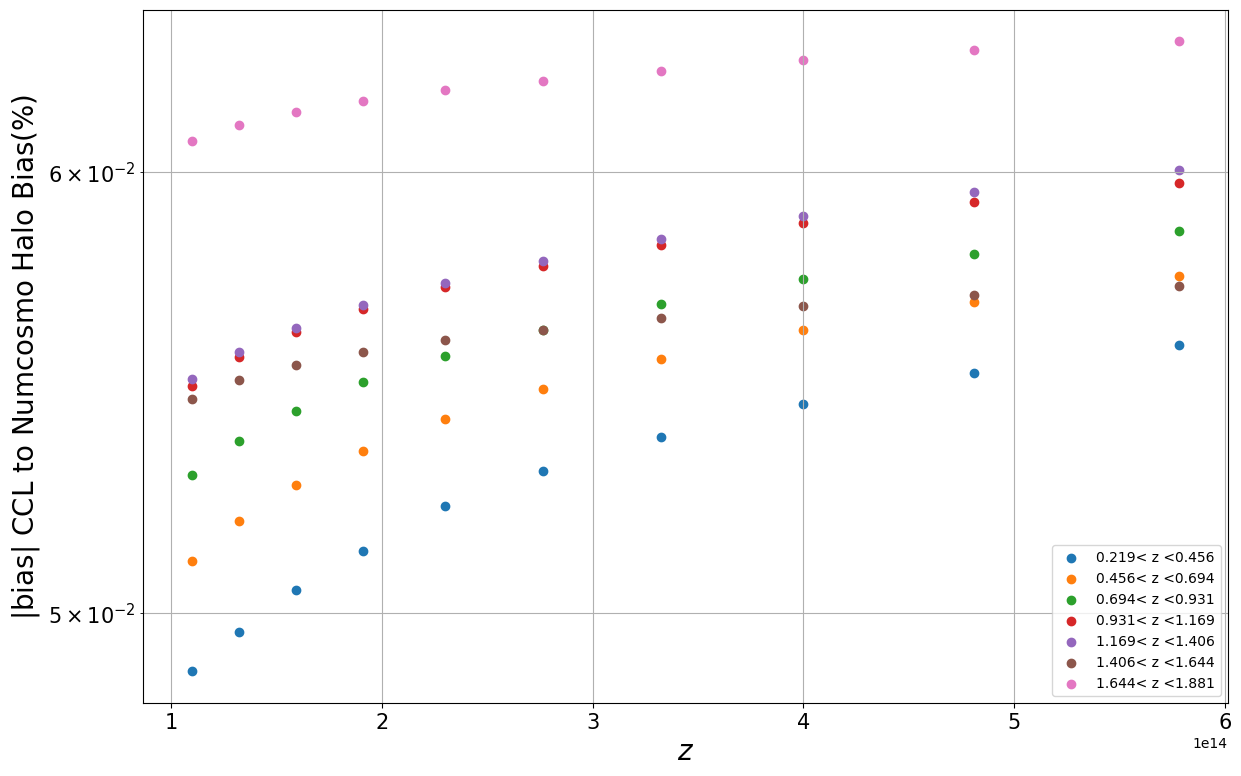

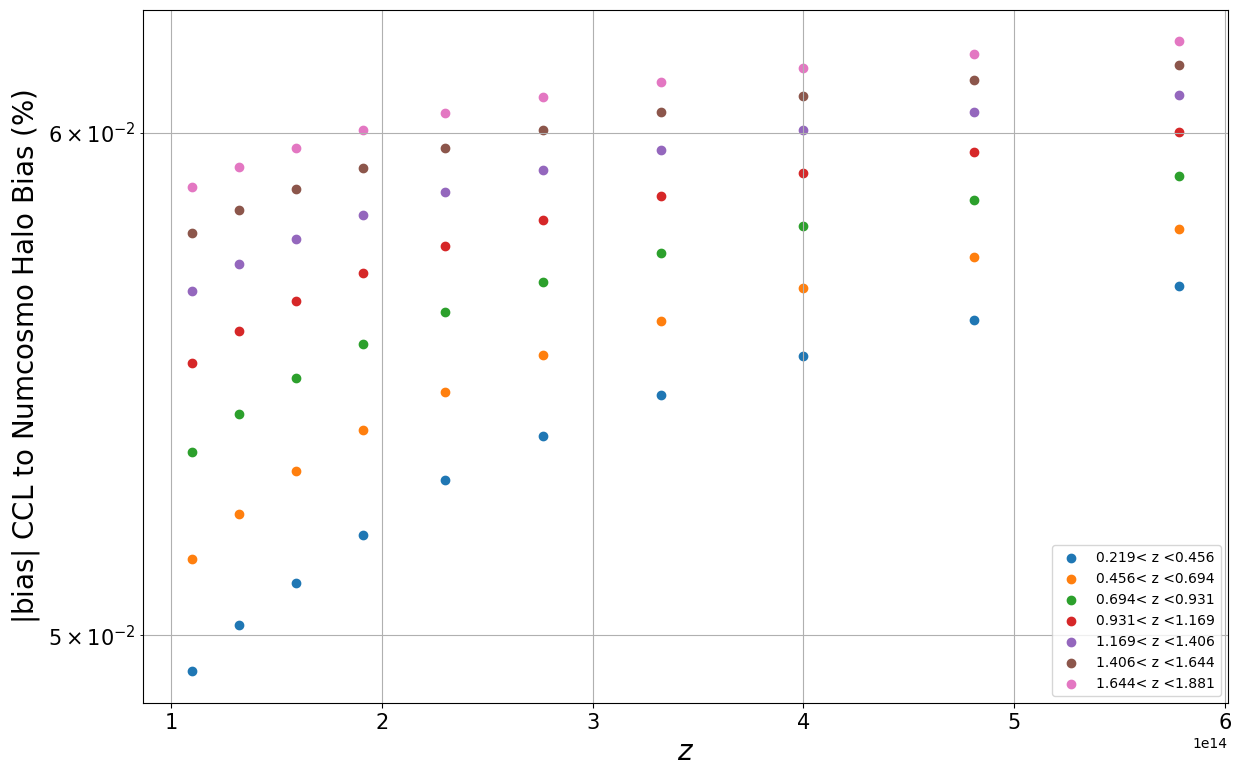

In [13]:
#default parameters
diff = []

for i in range(len(ccl_bias_default)):
    diff.append(100 * abs((Numcosmo_Bias[i] - ccl_bias_default[i]) / Numcosmo_Bias[i]))

plt.figure(figsize=(14, 9))
plt.yscale("log")
z_ = [np.mean([z_nodes[i], z_nodes[i + 1]]) for i in np.arange(len(z_nodes) - 1)]
mass = [
    np.mean([10 ** log10M_nodes[i], 10 ** log10M_nodes[i + 1]])
    for i in np.arange(len(log10M_nodes) - 1)
]

plt.tick_params(axis="both", which="both", labelsize=15)
legend = []
for i in range(len(z_)-1):
    plt.scatter(mass, diff[:][i])
    legend.append(str(round(z_[i], 3)) + "< z <" + str(round(z_[i + 1], 3)))
plt.legend(legend, loc=4, fontsize=10)
plt.grid(True, which="both")
plt.ylabel(r"|bias| CCL to Numcosmo Halo Bias$(\%)$", fontsize=20)
plt.xlabel(r"$z$", fontsize=20)
#plt.ylim(1e-9, 1e-1)
plt.show()


#high precision parameters
diff = []

for i in range(len(ccl_bias_high)):
    diff.append(100 * abs((Numcosmo_Bias[i] - ccl_bias_high[i]) / Numcosmo_Bias[i]))

plt.figure(figsize=(14, 9))
plt.yscale("log")
z_ = [np.mean([z_nodes[i], z_nodes[i + 1]]) for i in np.arange(len(z_nodes) - 1)]
mass = [
    np.mean([10 ** log10M_nodes[i], 10 ** log10M_nodes[i + 1]])
    for i in np.arange(len(log10M_nodes) - 1)
]

plt.tick_params(axis="both", which="both", labelsize=15)
legend = []
for i in range(len(z_)-1):
    plt.scatter(mass, diff[:][i])
    legend.append(str(round(z_[i], 3)) + "< z <" + str(round(z_[i + 1], 3)))
plt.legend(legend, loc=4, fontsize=10)
plt.grid(True, which="both")
plt.ylabel(r"|bias| CCL to Numcosmo Halo Bias $(\%)$", fontsize=20)
plt.xlabel(r"$z$", fontsize=20)
#plt.ylim(1e-9, 1e-1)
plt.show()